In [16]:
import gymnasium as gym
import random
import warnings
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict

warnings.filterwarnings("ignore")

In [17]:
class DoubleQLearning:
    def __init__(self, bin_list, num_episodes, gamma, epsilon, max_steps, alpha):
        self.bin_list = bin_list
        self.num_episodes = num_episodes
        self.gamma = gamma
        self.epsilon = epsilon
        self.max_steps = max_steps
        self.alpha = alpha

    def discretize(self, obs):
        idxs = [
            min(max(np.digitize(o, b) - 1, 0), len(b) - 1)
            for o, b in zip(obs, self.bin_list)
        ]
        return tuple(idxs)

    def decay_epsilon(self, rewards_log):
        avg_reward = np.mean(rewards_log[-10:])
        if avg_reward > 400:
            self.epsilon = 0.0001

    def fit(self, env, Q1, Q2):
        # 두 개의 Q 테이블 초기화
        rewards_log = []

        for _ in tqdm(range(self.num_episodes)):
            obs, info = env.reset()
            state = self.discretize(obs)
            total_reward = 0

            for _ in range(self.max_steps):
                # 행동 선택 (Q1 + Q2를 더한 값으로 ε-탐욕적 선택)
                if random.random() < self.epsilon:
                    action = random.randint(0, 1)
                else:
                    action = np.argmax(Q1[state] + Q2[state])

                obs_next, reward, done, truncated, info = env.step(action)
                next_state = self.discretize(obs_next)

                # 50% 확률로 Q1 또는 Q2 업데이트
                if random.random() < 0.5:
                    # Q1 업데이트: Q2를 사용하여 다음 상태의 최적 행동 결정
                    best_next_action = np.argmax(Q1[next_state])  # Q1에서 최적 행동 찾기
                    target = reward + self.gamma * Q2[next_state][best_next_action] if not done else reward
                    Q1[state][action] += self.alpha * (target - Q1[state][action])
                else:
                    # Q2 업데이트: Q1을 사용하여 다음 상태의 최적 행동 결정
                    best_next_action = np.argmax(Q2[next_state])  # Q2에서 최적 행동 찾기
                    target = reward + self.gamma * Q1[next_state][best_next_action] if not done else reward
                    Q2[state][action] += self.alpha * (target - Q2[state][action])

                total_reward += reward
                state = next_state  # SARSA와 다르게 다음 행동을 미리 선택하지 않음.

                if done:
                    break

            rewards_log.append(total_reward)
            self.decay_epsilon(rewards_log)

        env.close()
        return Q1, Q2, rewards_log

In [18]:
# 1) 환경 & 이산화 준비
env = gym.make('CartPole-v1')
num_bins = 8
# 관측 범위
ranges = [(-4.8, 4.8), (-3, 3), (-0.418, 0.418), (-4, 4)]
bins_list = [np.linspace(lo, hi, num_bins) for (lo, hi) in ranges]

# 2) Q, 카운트(점진적 평균)
Q1 = defaultdict(lambda: np.random.uniform(low=0, high=10, size=(env.action_space.n)).astype(np.float32))
Q2 = defaultdict(lambda: np.random.uniform(low=0, high=10, size=(env.action_space.n)).astype(np.float32))

In [19]:
QL = DoubleQLearning(bins_list, num_episodes=10000, gamma=0.99, epsilon=0.1, max_steps=500, alpha=0.3)
Q1, Q2, rewards = QL.fit(env, Q1, Q2)

100%|██████████| 10000/10000 [06:07<00:00, 27.20it/s] 


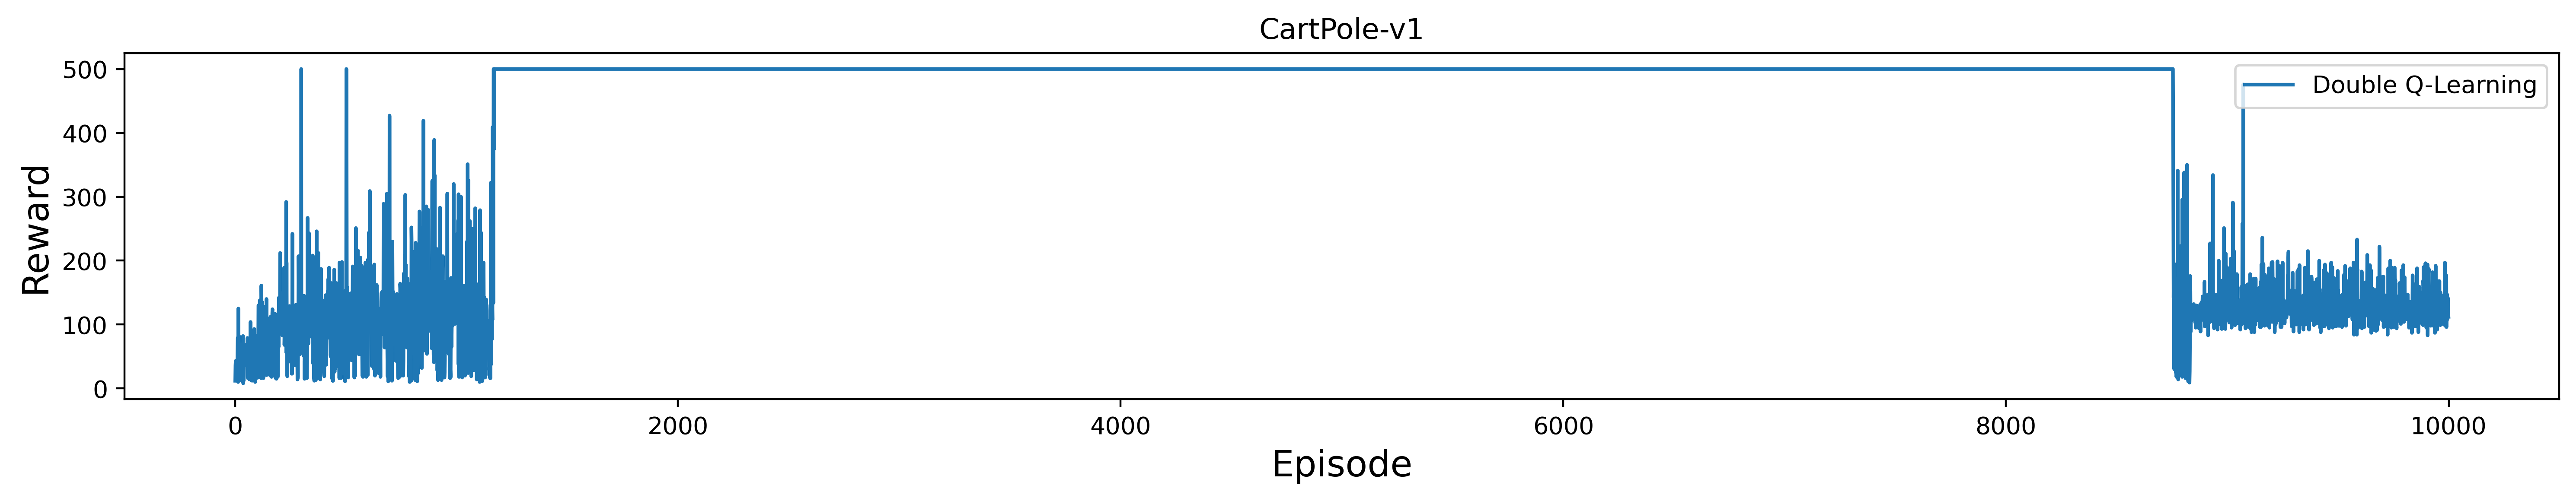

최종 epsilon: 0.0001
초반 10개 에피소드 보상: [12.0, 36.0, 43.0, 21.0, 20.0, 32.0, 44.0, 20.0, 18.0, 23.0]
마지막 10개 에피소드 보상: [96.0, 105.0, 138.0, 147.0, 108.0, 112.0, 142.0, 135.0, 116.0, 112.0]
최근 100 에피소드 평균 보상: 126.85


In [20]:
plt.figure(figsize=(15, 3), dpi=400)
plt.plot(np.array(rewards), label="Double Q-Learning")
plt.title('CartPole-v1')
plt.xlabel('Episode', fontsize=15)
plt.ylabel('Reward', fontsize=15)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

print(f"최종 epsilon: {QL.epsilon}")
print("초반 10개 에피소드 보상:", rewards[:10])
print("마지막 10개 에피소드 보상:", rewards[-10:])
avg_reward_recent = np.mean(rewards[-100:])
print(f"최근 100 에피소드 평균 보상: {avg_reward_recent:.2f}")